#Workation_Price_Prediction_Challenge

In [1]:
import numpy as np
import pandas as pd
import re
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder,OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')

In [2]:
train=pd.read_csv('/content/drive/MyDrive/Hackathon/Workation Price Prediction Challenge/Train.csv')
test=pd.read_csv('/content/drive/MyDrive/Hackathon/Workation Price Prediction Challenge/Test.csv')

In [3]:
test_data=test.copy()

In [4]:
train.head(3)

,Uniq Id,Package Name,Package Type,Destination,Itinerary,Places Covered,Travel Date,Hotel Details,Start City,Airline,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules,Per Person Price
0,e788ab76d9d8cf1e6ed2f139645ca5d1,Best of Shimla and Manali Holiday from Delhi,Standard,New Delhi|Shimla|Manali|Chandigarh,1N New Delhi . 2N Shimla . 2N Manali . 1N Chan...,New Delhi|Shimla|Manali|Chandigarh,30-07-2021,Not Available,Mumbai,Not Available,2,3,Not Available,Not Available,11509.0
1,178f892630ce3e335a5a41d5d83937fd,Kashmir Valley vacation,Premium,Srinagar|Pahalgam|Srinagar,1N Srinagar . 2N Pahalgam . 1N Srinagar,Srinagar|Pahalgam|Srinagar,08-12-2021,The Orchard Retreat & Spa:4.6|WelcomHotel Pine...,New Delhi,IndiGo|IndiGo,0,5,Dal Lake | Avantipura Ruins | Mughal Gardens ...,Cancellation any time after making the 1st pay...,22485.5
2,f060f2954840503cc2fdaf495357b7df,Might of Mewar- Udaipur and Chittorgarh,Luxury,Udaipur|Chittorgarh,2N Udaipur . 1N Chittorgarh,Udaipur|Chittorgarh,26-04-2021,The Ananta:4.4|juSTa Lake Nahargarh Palace:4,New Delhi,IndiGo,0,4,Lake Pichola | Jag Mandir Palace | Saheliyon ...,Cancellation any time after making the 1st pay...,12421.5


In [5]:
train.drop(['Uniq Id','Places Covered'],axis=1,inplace=True)
test.drop(['Uniq Id','Places Covered'],axis=1,inplace=True)

In [6]:
train['Travel Date']=pd.to_datetime(train['Travel Date'])
test['Travel Date']=pd.to_datetime(test['Travel Date'])

In [7]:
train['Travel Year']=train['Travel Date'].dt.year
train['Travel Month']=train['Travel Date'].dt.month

In [8]:
test['Travel Year']=test['Travel Date'].dt.year
test['Travel Month']=test['Travel Date'].dt.month

In [9]:
train.drop(['Travel Date'],axis=1,inplace=True)
test.drop(['Travel Date'],axis=1,inplace=True)

In [10]:
train.head(2)

,Package Name,Package Type,Destination,Itinerary,Hotel Details,Start City,Airline,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules,Per Person Price,Travel Year,Travel Month
0,Best of Shimla and Manali Holiday from Delhi,Standard,New Delhi|Shimla|Manali|Chandigarh,1N New Delhi . 2N Shimla . 2N Manali . 1N Chan...,Not Available,Mumbai,Not Available,2,3,Not Available,Not Available,11509.0,2021,7
1,Kashmir Valley vacation,Premium,Srinagar|Pahalgam|Srinagar,1N Srinagar . 2N Pahalgam . 1N Srinagar,The Orchard Retreat & Spa:4.6|WelcomHotel Pine...,New Delhi,IndiGo|IndiGo,0,5,Dal Lake | Avantipura Ruins | Mughal Gardens ...,Cancellation any time after making the 1st pay...,22485.5,2021,8


In [11]:
train['Total Destination']=train['Destination'].apply(lambda x:len(x.split('|')))
test['Total Destination']=test['Destination'].apply(lambda x:len(x.split('|')))

In [12]:
train['Total Sightseeing Places Covered']=train['Sightseeing Places Covered'].apply(lambda x:len(x.split('|'))if x!='Not Available' else -1)
test['Total Sightseeing Places Covered']=test['Sightseeing Places Covered'].apply(lambda x:len(x.split('|'))if x!='Not Available' else -1)

In [13]:
train['Total Night Stay']=train['Itinerary'].apply(lambda x:sum(int(i)for i in re.findall(r'[0-9]',x)))
test['Total Night Stay']=test['Itinerary'].apply(lambda x:sum(int(i)for i in re.findall(r'[0-9]',x)))

In [14]:
train['Hotel Details'][1]

'The Orchard Retreat & Spa:4.6|WelcomHotel Pine N Peak Pahalgam - Member ITC Hotel Group:4.1|The Orchard Retreat & Spa:4.6'

In [15]:
train['Hotel Details']=train['Hotel Details'].str.replace(":","")
test['Hotel Details']=test['Hotel Details'].str.replace(":","")

In [16]:
train['Hotel Rating']=train['Hotel Details'].apply(lambda x:sum(float(i) for i in re.findall(r'[0-9]*[.][0-9]',x))/len(re.findall(r'[0-9][.][0-9]',x))if len(re.findall(r'[0-9][.][0-9]',x))!=0 else -1)

In [17]:
test['Hotel Rating']=test['Hotel Details'].apply(lambda x:sum(float(i) for i in re.findall(r'[0-9]*[.][0-9]',x))/len(re.findall(r'[0-9][.][0-9]',x))if len(re.findall(r'[0-9][.][0-9]',x))!=0 else -1)

In [18]:
train.head(2)

,Package Name,Package Type,Destination,Itinerary,Hotel Details,Start City,Airline,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules,Per Person Price,Travel Year,Travel Month,Total Destination,Total Sightseeing Places Covered,Total Night Stay,Hotel Rating
0,Best of Shimla and Manali Holiday from Delhi,Standard,New Delhi|Shimla|Manali|Chandigarh,1N New Delhi . 2N Shimla . 2N Manali . 1N Chan...,Not Available,Mumbai,Not Available,2,3,Not Available,Not Available,11509.0,2021,7,4,-1,6,-1.000000
1,Kashmir Valley vacation,Premium,Srinagar|Pahalgam|Srinagar,1N Srinagar . 2N Pahalgam . 1N Srinagar,The Orchard Retreat & Spa4.6|WelcomHotel Pine ...,New Delhi,IndiGo|IndiGo,0,5,Dal Lake | Avantipura Ruins | Mughal Gardens ...,Cancellation any time after making the 1st pay...,22485.5,2021,8,3,7,4,4.433333


In [19]:
train['Total Destination Per Day']=train['Total Destination']/train['Total Night Stay']
train['Total Sightseeing Places Covered Per Day']=train['Total Sightseeing Places Covered']/train['Total Night Stay']

In [20]:
test['Total Destination Per Day']=test['Total Destination']/test['Total Night Stay']
test['Total Sightseeing Places Covered Per Day']=test['Total Sightseeing Places Covered']/test['Total Night Stay']

In [21]:
train.head(2)

,Package Name,Package Type,Destination,Itinerary,Hotel Details,Start City,Airline,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules,Per Person Price,Travel Year,Travel Month,Total Destination,Total Sightseeing Places Covered,Total Night Stay,Hotel Rating,Total Destination Per Day,Total Sightseeing Places Covered Per Day
0,Best of Shimla and Manali Holiday from Delhi,Standard,New Delhi|Shimla|Manali|Chandigarh,1N New Delhi . 2N Shimla . 2N Manali . 1N Chan...,Not Available,Mumbai,Not Available,2,3,Not Available,Not Available,11509.0,2021,7,4,-1,6,-1.000000,0.666667,-0.166667
1,Kashmir Valley vacation,Premium,Srinagar|Pahalgam|Srinagar,1N Srinagar . 2N Pahalgam . 1N Srinagar,The Orchard Retreat & Spa4.6|WelcomHotel Pine ...,New Delhi,IndiGo|IndiGo,0,5,Dal Lake | Avantipura Ruins | Mughal Gardens ...,Cancellation any time after making the 1st pay...,22485.5,2021,8,3,7,4,4.433333,0.750000,1.750000


In [22]:
ordinal_columns=['Package Type','Start City','Destination','Cancellation Rules']

In [23]:
oe=OrdinalEncoder()
def Ordinal_Transform(df,column):
  df[column]=oe.fit_transform(df[column])
  return df

In [24]:
train=Ordinal_Transform(train,ordinal_columns)

In [25]:
test=Ordinal_Transform(test,ordinal_columns)

In [26]:
train.head(2)

,Package Name,Package Type,Destination,Itinerary,Hotel Details,Start City,Airline,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules,Per Person Price,Travel Year,Travel Month,Total Destination,Total Sightseeing Places Covered,Total Night Stay,Hotel Rating,Total Destination Per Day,Total Sightseeing Places Covered Per Day
0,Best of Shimla and Manali Holiday from Delhi,4.0,417.0,1N New Delhi . 2N Shimla . 2N Manali . 1N Chan...,Not Available,0.0,Not Available,2,3,Not Available,5.0,11509.0,2021,7,4,-1,6,-1.000000,0.666667,-0.166667
1,Kashmir Valley vacation,3.0,533.0,1N Srinagar . 2N Pahalgam . 1N Srinagar,The Orchard Retreat & Spa4.6|WelcomHotel Pine ...,1.0,IndiGo|IndiGo,0,5,Dal Lake | Avantipura Ruins | Mughal Gardens ...,0.0,22485.5,2021,8,3,7,4,4.433333,0.750000,1.750000


In [27]:
Tfidf_columns=['Package Name','Itinerary','Hotel Details','Airline','Sightseeing Places Covered']

In [28]:
def TFIDF_TRANSFORM(train,test,column):
  tfidf=TfidfVectorizer()
  train_features=tfidf.fit_transform(train[column])
  train_features=pd.DataFrame(train_features.todense(),columns=[(column+str(i)) for i in range(len(tfidf.get_feature_names()))])
  train=pd.concat([train,train_features],axis=1)

  test_feature = tfidf.transform(test[column])
  test_feature = pd.DataFrame(test_feature.todense(), columns=[(column+str(i)) for i in range(len(tfidf.get_feature_names()))])
  test = pd.concat([test, test_feature], axis=1)
  yield train,test

In [29]:
for col in Tfidf_columns:
  train,test=next(TFIDF_TRANSFORM(train,test,col))

In [30]:
train.shape

(21000, 4831)

In [31]:
train.drop(Tfidf_columns,axis=1,inplace=True)
test.drop(Tfidf_columns,axis=1,inplace=True)

In [32]:
print(train.shape)
print(test.shape)

(21000, 4826)
(9000, 4825)


In [33]:
X=train.drop(['Per Person Price'],axis=1)
y=train['Per Person Price']

In [34]:
scaler=StandardScaler()
X=pd.DataFrame(scaler.fit_transform(X),columns=X.columns)
X

,Package Type,Destination,Start City,Flight Stops,Meals,Cancellation Rules,Travel Year,Travel Month,Total Destination,Total Sightseeing Places Covered,Total Night Stay,Hotel Rating,Total Destination Per Day,Total Sightseeing Places Covered Per Day,Package Name0,Package Name1,Package Name2,Package Name3,Package Name4,Package Name5,Package Name6,Package Name7,Package Name8,Package Name9,Package Name10,Package Name11,Package Name12,Package Name13,Package Name14,Package Name15,Package Name16,Package Name17,Package Name18,Package Name19,Package Name20,Package Name21,Package Name22,Package Name23,Package Name24,Package Name25,...,Sightseeing Places Covered1398,Sightseeing Places Covered1399,Sightseeing Places Covered1400,Sightseeing Places Covered1401,Sightseeing Places Covered1402,Sightseeing Places Covered1403,Sightseeing Places Covered1404,Sightseeing Places Covered1405,Sightseeing Places Covered1406,Sightseeing Places Covered1407,Sightseeing Places Covered1408,Sightseeing Places Covered1409,Sightseeing Places Covered1410,Sightseeing Places Covered1411,Sightseeing Places Covered1412,Sightseeing Places Covered1413,Sightseeing Places Covered1414,Sightseeing Places Covered1415,Sightseeing Places Covered1416,Sightseeing Places Covered1417,Sightseeing Places Covered1418,Sightseeing Places Covered1419,Sightseeing Places Covered1420,Sightseeing Places Covered1421,Sightseeing Places Covered1422,Sightseeing Places Covered1423,Sightseeing Places Covered1424,Sightseeing Places Covered1425,Sightseeing Places Covered1426,Sightseeing Places Covered1427,Sightseeing Places Covered1428,Sightseeing Places Covered1429,Sightseeing Places Covered1430,Sightseeing Places Covered1431,Sightseeing Places Covered1432,Sightseeing Places Covered1433,Sightseeing Places Covered1434,Sightseeing Places Covered1435,Sightseeing Places Covered1436,Sightseeing Places Covered1437
0,1.247239,0.761160,-1.374691,1.353001,-0.744652,1.207148,-0.205638,0.155492,1.116925,-1.691008,0.709795,-0.114920,0.698559,-1.652254,-0.009635,-0.026705,-0.026705,-0.016899,-0.020706,-0.01826,-0.038361,-0.091953,-0.01375,-0.09068,-0.038442,-0.085166,-0.034153,-0.070404,-0.046299,-0.043094,-0.011953,-0.01826,-0.12594,-0.011953,-0.019507,-0.038448,-0.031639,-0.025757,-0.033819,-0.129562,...,-0.155686,-0.044246,-0.011953,-0.177775,-0.074353,-0.022728,-0.016906,-0.009759,-0.039464,-0.207179,-0.221980,-0.079799,-0.025828,-0.026354,-0.02929,-0.016906,-0.024888,-0.200633,-0.021827,-0.013803,-0.051218,-0.336436,-0.145587,-0.062135,-0.018123,-0.01826,-0.009759,-0.046415,-0.063464,-0.016906,-0.022893,-0.01826,-0.030733,-0.025828,-0.122633,-0.026694,-0.037544,-0.087688,-0.304886,-0.226309
1,0.429224,1.487340,0.727436,-1.042296,1.493461,-0.430075,-0.205638,0.464797,0.344450,-0.076359,-0.408034,-0.109451,1.155833,0.129924,-0.009635,-0.026705,-0.026705,-0.016899,-0.020706,-0.01826,-0.038361,-0.091953,-0.01375,-0.09068,-0.038442,-0.085166,-0.034153,-0.070404,-0.046299,-0.043094,-0.011953,-0.01826,-0.12594,-0.011953,-0.019507,-0.038448,-0.031639,-0.025757,-0.033819,-0.129562,...,-0.155686,-0.044246,-0.011953,-0.177775,-0.074353,-0.022728,-0.016906,-0.009759,-0.039464,-0.207179,-0.221980,-0.079799,-0.025828,-0.026354,-0.02929,-0.016906,-0.024888,-0.200633,-0.021827,-0.013803,-0.051218,-0.336436,-0.145587,-0.062135,-0.018123,-0.01826,-0.009759,-0.046415,-0.063464,-0.016906,-0.022893,-0.01826,-0.030733,-0.025828,-0.122633,-0.026694,-0.037544,-0.087688,-0.304886,-0.226309
2,-0.388791,1.587503,0.727436,-1.042296,0.374404,-0.430075,-0.205638,-0.772422,-0.428025,0.125472,-0.966949,-0.109484,0.698559,0.982270,-0.009635,-0.026705,-0.026705,-0.016899,-0.020706,-0.01826,-0.038361,-0.091953,-0.01375,-0.09068,-0.038442,-0.085166,-0.034153,-0.070404,-0.046299,-0.043094,-0.011953,-0.01826,-0.12594,-0.011953,-0.019507,-0.038448,-0.031639,-0.025757,-0.033819,-0.129562,...,-0.155686,-0.044246,-0.011953,-0.177775,-0.074353,-0.022728,-0.016906,-0.009759,-0.039464,-0.207179,-0.221980,-0.079799,-0.025828,-0.026354,-0.02929,-0.0

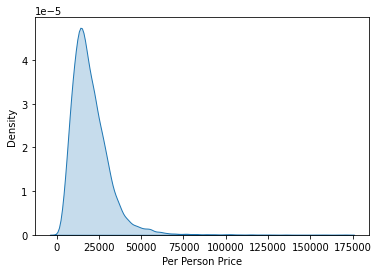

In [35]:
sns.kdeplot(data=y,shade=True)

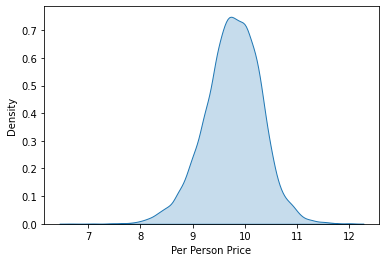

In [36]:
sns.kdeplot(data=np.log(y),shade=True)

In [37]:
X_train,X_test,y_train,y_test=train_test_split(X,np.log(y),test_size=0.3,random_state=42)

In [38]:
from lightgbm import LGBMRegressor

In [39]:
LGB=LGBMRegressor()

In [40]:
LGB.fit(X_train,y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [41]:
LGB.score(X_test,y_test)

0.8917600907887835

In [42]:
LGB_new=LGBMRegressor(n_estimators=500,
                  min_child_samples=19,
                  num_leaves=48)

In [43]:
LGB_new.fit(X_train,y_train)
LGB_new.score(X_test,y_test)

0.9089223580537051

In [44]:
y_pred=LGB_new.predict(X_test)

In [45]:
preds=pd.DataFrame()
preds['real price']=np.expm1(y_test)

In [46]:
preds['Price Predicted By Model']=np.expm1(y_pred)

In [52]:
mean_squared_error(y_test,y_pred)

0.026956089595520878

In [47]:
preds

,real price,Price Predicted By Model
2312,20898.5,20613.537394
16845,13768.5,15274.167858
6105,29866.0,27895.447768
18082,12628.5,13328.209860
11335,25511.0,28764.989150
...,...,...
2562,26370.0,26144.023165
19682,12075.5,11683.266620
19988,15235.0,16901.214944
3198,7309.0,7473.586233


In [48]:
test_price=LGB_new.predict(test)

In [49]:
tests=pd.DataFrame()
tests['Price Predicted by model']=np.expm1(test_price)

In [50]:
tests

,Price Predicted by model
0,45765.844986
1,31625.802249
2,18087.061052
3,18661.257598
4,39659.253560
...,...
8995,35197.796993
8996,30353.653700
8997,41195.705422
8998,30686.224440


In [51]:
test_data=pd.concat([test_data,tests],axis=1)
test_data

,Uniq Id,Package Name,Package Type,Destination,Itinerary,Places Covered,Travel Date,Hotel Details,Start City,Airline,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules,Price Predicted by model
0,12c47aefbcca65d6156ba0bc7946704b,Goa 5N stay with flights & Transfers-North Goa,Luxury,Goa,5N Goa,Goa,13-07-2021,Novotel Goa Resort & Spa:4.1,New Delhi,IndiGo,0,4,Not Available,Cancellation any time after making the 1st pay...,45765.844986
1,156febf7d27315ae9f210ed13bca3ac2,Into the Wild - Weekend at Bandipur National Park,Luxury,Bandipur,2N Bandipur,Bandipur,20-03-2021,The Windflower Jungle Resorts & Spa Bandipur:4.4,New Delhi,Not Available,0,4,Bandipur National Park,This cancellation policy is applicable for boo...,31625.802249
2,a7f43314e3ee6464a4e35b874bddf2ea,Unforgettable Munnar Getaway - Private Picnic ...,Standard,Munnar,3N Munnar,Munnar,09-02-2022,Not Available,New Delhi,Not Available,2,3,Old Munnar Town | Eravikulam national park | ...,This cancellation policy is applicable for boo...,18087.061052
3,d9cc4b407f3d5d290560c03d9ac71035,Munnar for Adventure Lovers - Top Valley Trek,Deluxe,Munnar,3N Munnar,Munnar,16-05-2021,Not Available,Mumbai,Not Available,1,3,Tata Tea Museum | Eravikulam national park | ...,This cancellation policy is applicable for boo...,18661.257598
4,b3bbc8aa6429feb260e9ac0a91f252c4,Splendours of Kerala - Make your own Tea,Luxury,Cochin|Munnar|Thekkady|Allepey,1N Cochin . 2N Munnar . 1N Thekkady . 1N Allepey,Cochin|Munnar|Thekkady|Allepey,13-10-2021,Casino Hotel - Cgh Earth-MMT Holidays Special:...,New Delhi,IndiGo,0,4,Fort Cochin | Dutch Palace | Jewish Synagogue...,Cancellation any time after making the 1st pay...,39659.253560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,75171484ea20440a5c08fe040a9a01a7,Trip to Kerala,Standard,Munnar|Thekkady|Allepey,2N Munnar . 1N Thekkady . 1N Allepey,Munnar|Thekkady|Allepey,04-06-2021,Iceberg Hill Hotel-MMT Holidays Special:4|Elep...,New Delhi,Vistara,2,3,Valara Waterfalls | Tea Plantation at Devikul...,Cancellation any time after making the 1st pay...,35197.796993
8996,16f57cebfb653f2c532314322598ca3a,Magical Kashmir Holiday,Deluxe,Srinagar|Pahalgam|Srinagar|Gulmarg,1N Srinagar . 1N Pahalgam . 1N Srinagar . 1N G...,Srinagar|Pahalgam|Srinagar|Gulmarg,07-03-2021,California Group of Houseboats:Three|The China...,Mumbai,IndiGo,1,3,Dal Lake | Pahalgam | Avantipura Ruins | Beta...,Cancellation any time after making the 1st pay...,30353.653700
8997,477f8b3f07e1a6c027152e2cd5d67e4a,Holiday in Dharamshala and Dalhousie from Delhi,Luxury,Dharamshala|Dalhousie,3N Dharamshala . 2N Dalhousie,Dharamshala|Dalhousie,21-08-2021,Little Mastiff Dharamshala - Unit Of Pong View...,Mumbai,Vistara,0,4,Dalai Lama temple | Bhagsu falls | Church of ...,Cancellation any time after making the 1st pay...,41195.705422
8998,c9ce916ec5e1b93134a2f84090284bf9,"Colorful Rajasthan- Jaipur, Jodhpur, Jaisalmer...",Deluxe,Jaipur|Jodhpur|Jaisalmer|Udaipur,2N Jaipur . 1N Jodhpur . 2N Jaisalmer . 2N Uda...,Jaipur|Jodhpur|Jaisalmer|Udaipur,19-03-2021,Souvenir Peppermint:3.9|Lariya Resort:4.3|Gorb...,New Delhi,IndiGo|IndiGo,1,3,City Palace | Hawa Mahal | Jantar Mantar | Ra...,Cancellation any time after making the 1st pay...,30686.224440
